In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/my-private-datasets/quotes_rus/quotes_pattern01.txt
/kaggle/input/my-private-datasets/quotes_rus/quotes_pattern04.txt
/kaggle/input/my-private-datasets/quotes_rus/quotes_pattern03.txt
/kaggle/input/my-private-datasets/quotes_rus/quotes_pattern06.txt
/kaggle/input/my-private-datasets/quotes_rus/quotes_pattern05.txt
/kaggle/input/my-private-datasets/quotes_rus/quotes_pattern07.txt
/kaggle/input/my-private-datasets/quotes_rus/quotes_pattern02.txt
/kaggle/input/my-private-datasets/CVBooks/SoT_CV-Jr_2018_rus.txt
/kaggle/input/my-private-datasets/CVBooks/ollection_of_quotes_2015_rus.txt
/kaggle/input/my-private-datasets/CVBooks/rus/3rdAlt_2017.txt
/kaggle/input/my-private-datasets/CVBooks/rus/7h_1998.txt
/kaggle/input/my-private-datasets/CVBooks/rus/LonP_2008.txt
/kaggle/input/my-private-datasets/CVBooks/rus/7h_fam_2007.txt
/kaggle/input/my-private-datasets/CVBooks/rus/PredRes_2010.txt
/kaggle/input/my-private-datasets/CVBooks/rus/8h_2017.txt
/kaggle/input/my-private-datasets/C

# Генерация текста с помощью RNN


(по мотивам [семинара](https://github.com/neychev/harbour_dlia2019/blob/master/day02_Simple_RNN/Day_2_Simple_RNN_pytorch.ipynb)
 [курса "Deep Learning in Applications"](https://in.harbour.space/data-science/deep-learning-in-applications-radoslav-neychev-anastasia-ianina/))

In [2]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

In [3]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Данные
Датасет содержит ~9k имен, все написаны латиницей.

In [4]:
# # Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
# !mkdir ./stepik-dl-nlp
# !mkdir ./stepik-dl-nlp/datasets
# !curl "https://raw.githubusercontent.com/Samsung-IT-Academy/stepik-dl-nlp/master/datasets/russian_names.txt" -o ./stepik-dl-nlp/datasets/russian_names.txt
# with open('./stepik-dl-nlp/datasets/russian_names.txt') as input_file:
#     names = input_file.read()[:-1].split('\n')
#     names = [' ' + line for line in names]

In [5]:
# names[:5]

Посмотрим на распределение длин имен:

In [6]:
# plt.title('Name length distribution')
# plt.hist(list(map(len, names)), bins=25);

# Препроцессинг

In [7]:
# #all unique characters go here
# tokens = list(set(''.join(names)))

# num_tokens = len(tokens)
# print ('num_tokens = ', num_tokens)

### Символы -> id

Создадим словарь < символ > -> < id >

In [8]:
# token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [9]:
# assert len(tokens) == len(token_to_id), "dictionaries must have same size"

# for i in range(num_tokens):
#     assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

# print("Seems alright!")

In [10]:
def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [11]:
# #Example: cast 4 names to matrices, pad with zeros
# print('\n'.join(names[::2000]))
# print(to_matrix(names[::2000], token_to_id))

# Рекуррентные нейронные сети

<img src="https://raw.githubusercontent.com/Samsung-IT-Academy/stepik-dl-nlp/master/img/rnn.png" width=480>

In [12]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
# class CharRNNCell(nn.Module):
#     """
#     Implement the scheme above as torch module
#     """
#     #в baseline num_tokens=52 (это размер словаря), embedding_size=16, rnn_num_units=64
#     def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
#         super(self.__class__,self).__init__()
#         #по сути длина вектора скрытого состояния для каждого символа,
#         #в процессе forward эти вектора конкатинируются сразу за эмбеддингом символа
#         #итого, вектор каждого символа состоит из склеенных: вектора эмбеддинга соответсвующего символа и 
#         #вектора скрытого состояния, с предыдущего шага, причем это скрытое состояние накапливается в процессе
#         #итераций перехода от предыдущего символа к следующему символу, т.е. получается, что вектор скрытого
#         #состояния не привязывается к каждому символу (токену) а изменяется/обучается на основе последовательностей
#         #этих символов (токенов)
#         self.num_units = rnn_num_units
        
#         self.embedding = nn.Embedding(num_tokens, embedding_size) #размер словаря x размер эмбеддинга
        
#         #линейный слой, состоящий из rnn_num_units нейронов, принимающий на вход emb_size + rnn_num_units значений
#         #линейная часть переходного состояния из предыдущего скрытого состояния к следующему
#         #т.е. на вход для каждого текущего i-го символа последовательности подаем вектора
#         #состоящие из склеенных эмбеддингов и вектора предыдущего скрытого состояния,
#         #на выходе получаем линейно преобразованные вектора следующего скрытого состояния
#         #итого, на последующее скрытое состояние влияет как вектор эмбеддинга текущего символа, так и предыдущее 
#         #скрытое состояние для текущего слова (или предложения) по которому происходит последовательное итерирование
#         #
#         #Важно! Глубоко задумался чем отличается RNN от обычного перцептрона, если здесь так же используются обычные 
#         #линейные слои. Так вот обучение этого линейного слоя (еще эмбеддингов и вероятностей ниже) выпонляется на 
#         #основе некоторого состояния ("скрытого состояния" по сути некоторого состояния памяти о предыдущих 
#         #                             событиях=символах/токенах, которые уже встретились), причем само это состояние 
#         #или память нигде не сохраняется, не обучается и т.д., т.е. в начале обработки или построения каждой 
#         #последовательности (слова или предложения) это скрытое состояние просто равно нулям, далее, исходя их 
#         #эмбеддингов и предыдущих состояний оно обновляется изменяется с переходом от одной позиции к следующей, и 
#         #именно на основе него и текущего эмбеддинга символа мы обучаем наши слои нейронов, после окончания текущей 
#         #последовательности, скрытое состояние нам боле не нужно, оно будет опять строиться заново в последующиех 
#         #итерациях (обучения или предсказания после полного обучения сети). Именно в этом главное отличие, которое не 
#         #может быть покрыто обычным перцептроном, в котором непонятно как подобную "память" или принятие решения на 
#         #основе уже сложившейся ситуации учитывать, например подавая на вход сразу все развернутые эмбеддинги всех 
#         #позиций в текущей последовательности + последовательность из нескольких линейных слоев, все же не будет 
#         #работать аналогичным образом, если еще учесть что на выходе мы должны получать вероятности для каждого 
#         #токена из словаря и для каждой позиции и с учетом предыдущих состояний, то это просто на выходе должно 
#         #было бы быть "космическое" число классов, растущее экспотенциально с ростом последовательности 
#         #и размером словаря. 
#         self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        
#         #линейный слой для вычисления вероятности для следующего символа, вероятность вычисляется 
#         #для каждого символа из словаря, на вход поступают вектора вычисленных следующих скрытых состояний,
#         #далее они линейно преобразуются через нейроны, каждый из которых соответствует id символа из словаря
#         #на вход подается тензор .shape = batch_size x rnn_num_units (для baseline [32, 64])
#         #на выходе получаем тензор .shape = batch_size x num_tokens=размер_словаря (для baseline [32, 52])
#         self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
#     def forward(self, x, h_prev):
#         """
#         This method computes h_next(x, h_prev) and log P(x_next | h_next)
#         We'll call it repeatedly to produce the whole sequence.
        
#         :param x: batch of character ids, variable containing vector of int64
#                   т.е. это одномерный тензор длины batch_size, содержащий в себе id i-го символа 
#                   в исходной последовательности, т.е. в цикле подаются 0, 1, 2 символы и т.д. до MAX_LENGTH
#         :param h_prev: previous rnn hidden states, variable containing matrix [batch, rnn_num_units] of float32
#                   в baseline h_prev.shape = [32, 64]
#         """
#         # get vector embedding of x
#         # преобразуем нашу строку i-х символов в эмбеддинги, 
#         # итого получаем тензор batch_size x embedding_size (для baseline x_emb.shape = [32, 16])
#         x_emb = self.embedding(x)
        
#         # compute next hidden state using self.rnn_update
#         #конкатенируем текущий входной тензор и скрытое состояние из предыдущего шага
#         #по итогу получаем тензор размера batch_size x (embedding_size + rnn_num_units)
#         #для нашего baseline x_and_h.shape = [32, 16+64] = [32, 80]
#         x_and_h = torch.cat([x_emb, h_prev], dim=1) #YOUR CODE HERE
        
#         #подробное описание дано в конструкторе перед инициализацией self.rnn_update
#         # для baseline h_next.shape = [32, 64]
#         h_next = self.rnn_update(x_and_h) #YOUR CODE HERE
        
#         #последующее нелинейное преобразование для нового скрытого состояния, по сути
#         #применение функции активации к линейному слою
#         h_next = F.tanh(h_next)
        
#         #просто проверяем, что все прошло как нужно и размеры предыдущего и следующего скрытого состояния равны
#         #если это не так, вызывается исключение assert
#         assert h_next.size() == h_prev.size()
                
#         #compute logits for next character probs
#         #подробное описание дано в конструкторе перед инициализацией self.rnn_to_logits
#         # для baseline logits..shape = batch_size x размер_словаря (для baseline [32, 52])
#         logits = self.rnn_to_logits(h_next)
        
#         #на выход мы передаём следующее скрытое состояние и log вероятностей для следующего символа,
#         #а именно, мы получим 52 log вероятности по каждому символу из нашего словаря.
#         # F.log_softmax(logits, -1) выполняется по последнему измерению и в итоге .shape 
#         #не изменяется, т.е.  F.log_softmax(logits, -1).shape = batch_size x размер_словаря
#         return h_next, F.log_softmax(logits, -1)
    
#     def initial_state(self, batch_size):
#         """ return rnn state before it processes first input (aka h0) """
#         #
#         #Variable - deprecated, как я понял, сейчас эта обертка ничего не делает
#         #т.е. это аналогично записи torch.zeros(batch_size, self.num_units)
#         return Variable(torch.zeros(batch_size, self.num_units))

In [14]:
#char_rnn = CharRNNCell()

### Тренировка сети, RNN loop

In [15]:
# #В ходе тренировки сети в цикле (в baseline - 1000 вызовов, т.е. 1000 эпох) выполняется 
# # logp_seq = rnn_loop(char_rnn, batch_ix), на вход подается (для baseline):
# # - модель (CharRNNCell)
# # - батч в виде рандомной выборки из списка имен (выбирается 32 имени), пропущенную через to_matrix 
# #   с параметром max_len=MAX_LENGTH (равен максимальной длине имени во всем датасете), итого, 
# #   получем тензор .shape=[32, 21] ([batch_size, MAX_LENGTH])

# def rnn_loop(rnn, batch_index):
#     """
#     Computes log P(next_character) for all time-steps in names_ix
#     :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
#     """
#     batch_size, max_length = batch_index.size() #32, 21
#     #return rnn state before it processes first input (aka h0)
#     #по факту возвращает тензор из 0. размера batch_size=32 x rnn_num_units=64
#     #выход функции "initial state" соответствует переменной "h0", 
#     #или нулевому скрытому состоянию нашей нейронной сети. 
#     #стоит отметить, что подобная инициализация проиходит в начале каждой мини-эпохи
#     hid_state = rnn.initial_state(batch_size)
#     logprobs = []

#     #после транспонирования, получаем тензор [MAX_LENGTH=21, batch_size=32]
#     #итерируемся по строкам, т.е. x_t = одномерному тензору длиной batch_size, 
#     #в котором мы последовательно продвигаемся по символам из последовательности
#     #в нашем случае, на первой итерации это 0 символ каждого стова из батча, 
#     #далее 1, 2 и т.д. до MAX_LENGTH
#     for x_t in batch_index.transpose(0,1): 
#         #hid_state.shape = [32, 64]
#         #logp_next.shape = [32, 52]
#         hid_state, logp_next = rnn(x_t, hid_state)
#         #накапливаем log вероятности для каждой позиции в последовательности
#         #в нашем случае для каждой позиции от 1 до MAX_LENGTH (от 1 до 21)
#         logprobs.append(logp_next)
    
#     #строим тензор из накопленных log вероятностей по dim=1, итого, размерность
#     #выходного тензора =  batch_size x MAX_LENGTH x размер_словаря
#     #return tensor.shape = [32, 21, 52]
#     return torch.stack(logprobs, dim=1)

### Тренировка сети

In [16]:
# from IPython.display import clear_output
# from random import sample

# char_rnn = CharRNNCell()
# opt = torch.optim.Adam(char_rnn.parameters())
# history = []

In [17]:
# MAX_LENGTH = max(map(len, names))

# #к слову, можно запускать этот цикл много раз, сеть будет дообучаться
# for i in range(1000): #1000
#     #батч в виде рандомной выборки из списка имен (выбирается 32 имени), пропущенную через to_matrix 
#     #с параметром max_len=MAX_LENGTH (равен максимальной длине имени во всем датасете), итого, 
#     #получем тензор .shape=[32, 21] ([batch_size, MAX_LENGTH])
#     batch_ix = to_matrix(sample(names, 32), token_to_id, max_len=MAX_LENGTH)
#     batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
#     #прогоняем один цикл по батчу, в ходе которого вычисляются/возвращаются вероятности
#     #встретить каждый символ/токен на следующей позиции, с учетом информации о всех предыдущих символах
#     #а именно, мы получим 52 вероятности по каждому символу из нашего словаря для каждой из 21 позиции
#     #logp_seq.shape = [32, 21, 52] (batch_size x MAX_LENGTH x Размер_словаря)
#     logp_seq = rnn_loop(char_rnn, batch_ix)
    
#     # for compute loss
#     #отбираем тензор предсказанных вероятностей для следующей позиции (т.е. без самого последнего предсказания,
#     #т.к. оно не имеет смысла), для каждого символа из словаря, итого имеем:
#     #predictions_logp.shape = batch_size x MAX_LENGTH - 1 x Размер_словаря (для baseline [32, 20, 52])
#     predictions_logp = logp_seq[:, :-1]
#     #отбираем тензор реальных id символов/токенов, которые находятся на соответсвующих позициях в нашем датасете
#     #нас интересуют символы/токены, только со 2-й позиции
#     #actual_next_tokens.shape = batch_size x MAX_LENGTH - 1 (для baseline [32, 20])
#     actual_next_tokens = batch_ix[:, 1:]

#     #суть кода ниже (loss), это выбор из тензора предсказанных log вероятностей для следующей позиции для каждого
#     #символа/тензора из словаря, т.е. только log-вероятностей, которые соответсвуют реальным символам/токенам, которые
#     #нашем датасете, далее берем среднее по всем этим вероятностям и инвертируем полученное значение, все это
#     #работает, т.к. ВСЕ выбранные log-вероятности должны в стремиться к максимуму (в данном конкретном случае, исходя из
#     #отдельно взятого конкретного слова/последовательности), т.к. мы видим, что именно этот символ/токен 
#     #встретился в нашем примере, как следствие, после инвертирования, чем больше будут все предсказанные
#     #вероятности на выбранных позициях (и среднее из них), тем меньше будет loss, что нам и нужно, причем, с учетом того,
#     #что это именно log-вероятности, до инвертирования, каждая отдельно взятая log вероятность будет в диапазоне (-inf, 0],
#     #после инвертирования, loss будет в диапазоне [0, +inf], минимум в 0, что нам и нужно для номального loss
#     #Более конкретно:
#     #actual_next_tokens[:,:,None] - добавляет еще одно измерение, в итоге .shape = [32, 20, 1], и в последнем 
#     #измерении мы получаем по одному id, которое по сути равно индексу (позиции) символа/токена в нашем словаре,
#     #добавление измерения и "перемещение" всех id в 3-е измерение необходимо для применения в torch.gather
#     #torch.gather здесь выбирает из последнего измерения тензора predictions_logp (предсказанные log-вероятности 
#     #для каждой позиции словаря) только позиции с индексами из actual_next_tokens, т.е. позиции соответсвующие
#     #реально увиденным в примере символам/токенам, итого получаем тензор .shape = [32, 20, 1], с предсказанными log-
#     #вероятностями только для таких реально увиденных символом/токенов, далее берем среднее и инвертируем результат
#     loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])) ###YOUR CODE
    
#     # train with backprop
#     loss.backward()
#     opt.step()
#     opt.zero_grad()
    
#     # visualizing training process
#     history.append(loss.data.numpy())
#     if (i + 1) % 100 == 0:
#         clear_output(True)
#         plt.plot(history,label='loss')
#         plt.legend()
#         plt.show()
    
#     #проверяем что наша сеть хоть немного обучилась - среднее из loss последних 10 циклов < среднего loss первых 10
# assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

### RNN: генерация имен

In [18]:
# #странно что мы не переводим сеть в обученный режим, думаю стоит добавить char_rnn.eval()
# def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
#     '''
#     The function generates text given a phrase of length at least SEQ_LENGTH.
#     :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
#     :param max_length: maximum output length, including seed_phrase
#     :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
#                         smaller temperature converges to the single most likely output
#     Примечание: функция генерирует только один пример, если нам нужно n-примеров, запускаем ее в цикле
#     '''
    
#     #переводим начальную фразу из токенов в тензор из соответсвующих токенам id
#     x_sequence = [token_to_id[token] for token in seed_phrase]
#     x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
#     #инициализируем нулевое скрытое состояние (получаем тензор из 0 размера 1 x rnn_num_units=64)
#     hid_state = char_rnn.initial_state(batch_size=1)
    
#     #feed the seed phrase, if any
#     #прогоняем сеть по заданной начальной последовательности, с целью получения текущего скрытого состояния
#     for i in range(len(seed_phrase) - 1):
#         hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
#     #start generating
#     for _ in range(max_length - len(seed_phrase)):
#         #получаем следующее скрытое состояние и log-вероятности для каждого символа/токена из словаря
#         hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        
#         #переводим log-вероятности, деленные на температуру, в вероятности для каждого символа/токена из словаря
#         #что бы понять смысл деления на температуру, нужно представить себе график прологарифмированных 
#         #вероятностей, это только так его часть, где по x значения от 0 до 1 (соответсвенно по y = (-inf, 0]), 
#         #так вот в случае температуры = 1 мы ничего не меняем и получаем исходные вероятности, те, которые были 
#         #до логарифмирования (далее по коду с этими вероятностями мы будем выбирать следующий символ/токен), если 
#         #температура > 1, мы деля на нее как бы сжимаем график по оси y, как следствие нивелируем разницу в 
#         #вероятностях для каждого символа быть следующим(в итоге вероятности будут более близки друг к другу и при 
#         #выборе следующего символа, мы получим более рандомный выбор), если температура < 1, то деля на нее, мы 
#         #растягиваем график по оси y, как следствие получим более выраженную разницу между вероятностями (итого 
#         #будет значительно больше вероятность выбрать символ, который на самом деле более часто встречается, при 
#         #температуре близкой к 0, мы почти всегда будет выбирать наиболее встречаемый символ/токен)
#         #смысл [0] - убрать лишнюю разменость, итого получаем одномерный тензор вероятностей для словаря
#         p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
#         #sample next token and push it back into x_sequence
#         #выбираем следующий символ исходя из полученных на шаге выше вероятностей, стоит отметить, что мы по сути,
#         #ничем не ограничивая данный выбор, можем выбрать даже самый не встречаемый символ, если его вероятность 
#         #будет хоть как то отличаться от 0
#         next_ix = np.random.choice(len(tokens), p=p_next)
#         next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
#         x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
#     return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [19]:
# for _ in range(10):
#     print(generate_sample(char_rnn))

In [20]:
# for _ in range(10):
#     print(generate_sample(char_rnn, seed_phrase=' Ar'))

In [21]:
# for _ in range(10):
#     print(generate_sample(char_rnn, seed_phrase=' Ar', temperature=0.01))

In [22]:
# for _ in range(10):
#     print(generate_sample(char_rnn, seed_phrase=' Ar', temperature=2))

### Более простое решение

* `nn.RNNCell(emb_size, rnn_num_units)` - шаг RNN. Алгоритм: concat-linear-tanh
* `nn.RNN(emb_size, rnn_num_units` - весь rnn_loop.

Кроме того, в PyTorch есть `nn.LSTMCell`, `nn.LSTM`, `nn.GRUCell`, `nn.GRU`, etc. etc.

Перепишем наш пример с генерацией имен с помощью средств PyTorch.

In [23]:
from IPython.display import clear_output
from random import sample

In [24]:
class RNNLoop(nn.Module):
    '''
    v1.2 changes:
         - add various RNN_class (nn.RNN, nn.GRU, or nn.LSTM)
    v1.1 changes:
         - added possibility to continue forward from custom initial hidden state
         - add rnn_num_layers
    '''
    def __init__(self, num_tokens, emb_size=16, RNN_class = nn.RNN, rnn_num_units=64, rnn_num_layers=1):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = RNN_class(emb_size, rnn_num_units, rnn_num_layers, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x):
        #batch_size x MAX_LENGTH
        #assert isinstance(x, Variable) and isinstance(x.data, torch.LongTensor)
        
        #self.emb(x).shape = batch_size x MAX_LENGTH x emb_size = [32, 21, 16]
        #h_seq.shape = batch_size x MAX_LENGTH x rnn_num_units = [32, 21, 64]
        h_seq, (_) = self.rnn(self.emb(x))
        
        #next_logits.shape = batch_size x MAX_LENGTH x Размер словаря = [32, 21, 52]
        next_logits = self.hid_to_logits(h_seq)
        
        #next_logp.shape = batch_size x MAX_LENGTH x Размер словаря = [32, 21, 52]
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp
    
    def forward_generate(self, x,  init_states=None):
        #batch_size x MAX_LENGTH
        assert isinstance(x, Variable) and isinstance(x.data, torch.LongTensor)
        
        if init_states is None:
            #self.emb(x).shape = batch_size x MAX_LENGTH x emb_size = [32, 21, 16]
            #h_seq.shape = batch_size x MAX_LENGTH x rnn_num_units = [32, 21, 64]
            h_seq, *final_states = self.rnn(self.emb(x))
        else:
            h_seq, *final_states = self.rnn(self.emb(x), *init_states)
        
        #next_logits.shape = batch_size x MAX_LENGTH x Размер словаря = [32, 21, 52]
        next_logits = self.hid_to_logits(h_seq)
        
        #next_logp.shape = batch_size x MAX_LENGTH x Размер словаря = [32, 21, 52]
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, final_states

In [25]:
def train_model(model, opt, dataset, token_to_id, history, num_loop=1000, batch_size=32, device='cpu'):
    train_start_time = datetime.datetime.now()
    if device == 'cuda':
        model.to(device)
    model.train()
    max_len = max(map(len, dataset))
    for i in range(num_loop):
        batch_ix = to_matrix(sample(dataset, batch_size), token_to_id, max_len=max_len)
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
        if device == 'cuda':
            batch_ix = batch_ix.to(device)
            
        logp_seq = model(batch_ix)

        # compute loss
        predictions_logp = logp_seq[:, :-1]
        actual_next_tokens = batch_ix[:, 1:]

        loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))

        # train with backprop
        loss.backward()
        opt.step()
        opt.zero_grad()

        history.append(loss.data.detach().cpu().numpy())
        if (i + 1) % 100 == 0:
            clear_output(True)
            plt.plot(history, label='loss')
            plt.legend()
            plt.show()
    
    print("Full train time = {:0.2f}s".format((datetime.datetime.now() - train_start_time).total_seconds()))
    assert np.mean(history[:25]) > np.mean(history[-25:]), "RNN didn't converge."
    
    if device == 'cuda':
        model.to('cpu')
        
    return model, history

In [26]:
#странно что мы не переводим сеть в обученный режим, думаю стоит добавить char_rnn.eval()
def generate_sample_loop(model, max_length, seed_phrase='_', temperature=1.0, word_tokenize=False):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    Примечание: функция генерирует только один пример, если нам нужно n-примеров, запускаем ее в цикле
    '''
    model.eval()
    
    if word_tokenize:
        seed_phrase = tokenizer.tokenize(seed_phrase)
    
    #переводим начальную фразу из токенов в тензор из соответсвующих токенам id
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    
    if (len(seed_phrase) > 1):
        _, init_states = model.forward_generate(x_sequence[:,:-1])
        
    else:
        init_states = None
        
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        #получаем следующее скрытое состояние и log-вероятности для каждого символа/токена из словаря
        logp_next, init_states  = model.forward_generate(x_sequence[:, -1:], init_states)
        
        #переводим log-вероятности, деленные на температуру, в вероятности для каждого символа/токена из словаря
        #что бы понять смысл деления на температуру, нужно представить себе график прологарифмированных 
        #вероятностей, это только так его часть, где по x значения от 0 до 1 (соответсвенно по y = (-inf, 0]), 
        #так вот в случае температуры = 1 мы ничего не меняем и получаем исходные вероятности, те, которые были 
        #до логарифмирования (далее по коду с этими вероятностями мы будем выбирать следующий символ/токен), если 
        #температура > 1, мы деля на нее как бы сжимаем график по оси y, как следствие нивелируем разницу в 
        #вероятностях для каждого символа быть следующим(в итоге вероятности будут более близки друг к другу и при 
        #выборе следующего символа, мы получим более рандомный выбор), если температура < 1, то деля на нее, мы 
        #растягиваем график по оси y, как следствие получим более выраженную разницу между вероятностями (итого 
        #будет значительно больше вероятность выбрать символ, который на самом деле более часто встречается, при 
        #температуре близкой к 0, мы почти всегда будет выбирать наиболее встречаемый символ/токен)
        #смысл [0] - убрать лишнюю разменость, итого получаем одномерный тензор вероятностей для словаря
        p_next = F.softmax(logp_next[0] / temperature, dim=-1).data.numpy()[0]
        
        #sample next token and push it back into x_sequence
        #выбираем следующий символ исходя из полученных на шаге выше вероятностей, стоит отметить, что мы по сути,
        #ничем не ограничивая данный выбор, можем выбрать даже самый не встречаемый символ, если его вероятность 
        #будет хоть как то отличаться от 0
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

### Что еще можно генерировать?
С помощью кода из этого семинара можно генерировать не только имена, но и:

* Повести/романы/поэзию/песни любимого автора
* Новостные заголовки
* Программный код
* Молекулы в формате [smiles](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system)
* Музыку
* Названия мебели из ИКЕА
* Мотивационные лозунги
* etc.

__Удачи!__

# Итоговое задание семинара 4.3.Final

## Использовать код семинара для решения задачи генерации русскоязычных текстов (цитат известных людей или иных предложений)

### Подготовка датасета

In [27]:
import re

def has_numbers(string):
    return bool(re.search(r'\d', string))

def rem_start_number(string):
    for i in range(len(string)):
        if not string[i].isdigit():
            break
    return string[i:]

quotes_rus = []
quotes_rus_dir = '/kaggle/input/my-private-datasets/quotes_rus/'
quotes_rus_filenames = []
for dirname, _, filenames in os.walk(quotes_rus_dir):
    for filename in filenames:
        quotes_rus_filenames.append(os.path.join(dirname, filename))
quotes_rus_filenames = sorted(quotes_rus_filenames)
print("\n".join(quotes_rus_filenames))

/kaggle/input/my-private-datasets/quotes_rus/quotes_pattern01.txt
/kaggle/input/my-private-datasets/quotes_rus/quotes_pattern02.txt
/kaggle/input/my-private-datasets/quotes_rus/quotes_pattern03.txt
/kaggle/input/my-private-datasets/quotes_rus/quotes_pattern04.txt
/kaggle/input/my-private-datasets/quotes_rus/quotes_pattern05.txt
/kaggle/input/my-private-datasets/quotes_rus/quotes_pattern06.txt
/kaggle/input/my-private-datasets/quotes_rus/quotes_pattern07.txt


In [28]:
###quotes_pattern01.txt
num = 0
with open(quotes_rus_filenames[num]) as file:
    lines = [line.rstrip() for line in file]
lines = list(filter(None, lines)) #remove empty strings
print('Сопроводительные комментарии к {}'.format(quotes_rus_filenames[num]))
print("\n".join([line for line in lines if line[0] == '#']))
print()

###Обработка
lines = [line.strip() for line in lines if line[0] != '#']

###Итоги и добавление в общий список
print("Количество: {}".format(len(lines)))
print("\n".join(lines[::len(lines)//10]))
quotes_rus.extend(lines)

Сопроводительные комментарии к /kaggle/input/my-private-datasets/quotes_rus/quotes_pattern01.txt
#Готовые фразы, нужно только удалить пустые строки

Количество: 234
Абсолютная власть развращает абсолютно
Велик русский бог
Германия превыше всего
Еще не вечер
История повторяется дважды…
Маленькая победоносная война
Не ошибается тот, кто ничего не делает
Оттепель
Пятая колонна
Так жить нельзя
Я готов целовать песок…


In [29]:
###quotes_pattern02.txt
num = 1
with open(quotes_rus_filenames[num]) as file:
    lines = [line.rstrip() for line in file]
lines = list(filter(None, lines)) #remove empty strings
print('Сопроводительные комментарии к {}'.format(quotes_rus_filenames[num]))
print("\n".join([line for line in lines if line[0] == '#']))
print()

###Обработка
lines = [line for line in lines if line[0] != '#']

#- оставить только строки которые следуют сразу за строкой, которая есть число 
lines = [line for line, prev_line in zip(lines[1:], lines[:-1]) if prev_line.isdigit()]

#- из этих строк удалить все, после символа // 
lines = [line.split('//')[0] for line in lines]

#-удалить все в скобках (), [], и убрать возникшие посторяющиеся пробелы
lines = [' '.join(re.sub("[\(\[].*?[\)\]]", "", line).split()) for line in lines]

#- удалить в начале строк "* " и "…"
lines = [line.lstrip('* ').lstrip('…') for line in lines]

#- удаляем строки в которых содержатся числа, т.к. во многих случаях такие строки 
#  содержат какие то пояснения, а не чистые цитата (их совсем немного, так что проще удалить)
#- финально удалить первоначальные и завершающие пробелы
lines = [line.strip() for line in lines if not has_numbers(line)]

#-удалить все сиволы '/ '
lines = [' '.join(line.split('/ ')) for line in lines]

###Итоги и добавление в общий список
print("Количество: {}".format(len(lines)))
print("\n".join(lines[::len(lines)//10]))
quotes_rus.extend(lines)

Сопроводительные комментарии к /kaggle/input/my-private-datasets/quotes_rus/quotes_pattern02.txt
#Действия следующие:
#- удалить пустые строки
#- оставить только строки которые следуют сразу за строкой, являющейся числом
#- из этих строк удалить все, после символа // и (
#- удалить в начале строк "* "
#- финально удалить первоначальные и завершающие пробелы
#ДАРИЙ I
#ДАРНЕЛЛ, Билл
#ДАРРЕ, Вальтер

Количество: 2446
Измена мне мила, а изменники противны.
Организатор победы.
Создание Берлинской республики.
Вижу, все пташки улетели.
Так это вы – та маленькая женщина, которая написала книгу, вызвавшую такую большую войну?
Европа – кротовая нора; великие империи и великие перевороты были возможны лишь на Востоке.
Все, что происходит сегодня в мире, <…> это следствие попыток внедрения <…> концепции однополярного мира. <…> Система права одного государства, прежде всего, конечно, Соединенных Штатов, перешагнула свои национальные границы во всех сферах <…>.
Прежде всего – не быть бедным.
Открыто

In [30]:
###quotes_pattern03.txt
num = 2
with open(quotes_rus_filenames[num]) as file:
    lines = [line.rstrip() for line in file]
lines = list(filter(None, lines)) #remove empty strings
print('Сопроводительные комментарии к {}'.format(quotes_rus_filenames[num]))
print("\n".join([line for line in lines if line[0] == '#']))
print()

###Обработка
lines = [line for line in lines if line[0] != '#']

#- взять только строки, начинающиеся с цифры
lines = [line for line in lines if line[0].isdigit()]

#- удалить вначале каждой строки "число"
lines = [rem_start_number(line).strip() for line in lines]

#- из этих строк удалить все, после символа // или '▪ '
#- финально удалить первоначальные и завершающие пробелы
lines = [line.split('//')[0].split('▪ ')[0].strip() for line in lines]

#-удалить все в скобках (), [], и убрать возникшие посторяющиеся пробелы
lines = [' '.join(re.sub("[\(\[].*?[\)\]]", "", line).split()) for line in lines]

#- оставить только строки завершающиеся на . или ! или ?
lines = [line for line in lines if line[-1] in ['.', '!', '?']]

#- удалить в начале строк "* " и "…"
lines = [line.lstrip('* ').lstrip('…') for line in lines]

#-убрать строки, содержащие ')'
lines = [line for line in lines if ')' not in line]

#- удаляем строки в которых содержатся числа, т.к. во многих случаях такие строки 
#  содержат какие то пояснения, а не чистые цитата (их совсем немного, так что проще удалить)
lines = [line.strip() for line in lines if not has_numbers(line)]

#-удалить все сиволы '/ '
lines = [' '.join(line.split('/ ')) for line in lines]

###Итоги и добавление в общий список
print("Количество: {}".format(len(lines)))
print("\n".join(lines[::len(lines)//10]))
quotes_rus.extend(lines)

Сопроводительные комментарии к /kaggle/input/my-private-datasets/quotes_rus/quotes_pattern03.txt
#Действия следующие:
#- взять только строки, начинающиеся с цифры
#- удалить вначале каждой строки "число"
#- из этих строк удалить все, после символа //
#- финально удалить первоначальные и завершающие пробелы
#- оставить только строки завершающиеся на . или ! или ?
#- удалить в начале строк "* "

Количество: 13860
Язык порождается мышлением и порождает мышление.
Она была народной принцессой, и останется ею в наших сердцах и нашей памяти навсегда.
Способность краснеть – самое характерное и самое человеческое из всех человеческих свойств.
У нее <…> черный ребенок! <…> У белой женщины черный ребенок!
Ограниченная война.
Если бы цивилизация оставалась в руках женщин, мы все еще жили бы в соломенных хижинах.
Господа офицеры! Какой восторг!
Где Жизнь, которую мы потеряли в жизни?
Не заграждай рта у вола молотящего.
Константинопольский епископ да имеет преимущества чести по римском епископе, пот

In [31]:
###quotes_pattern04.txt
num = 3
with open(quotes_rus_filenames[num]) as file:
    lines = [line.rstrip() for line in file]
lines = list(filter(None, lines)) #remove empty strings
print('Сопроводительные комментарии к {}'.format(quotes_rus_filenames[num]))
print("\n".join([line for line in lines if line[0] == '#']))
print()

###Обработка
lines = [line for line in lines if line[0] != '#']

#- финально удалить первоначальные и завершающие пробелы
lines = [line.strip() for line in lines]

#- оставить только строки завершающиеся на . или ! или ?
lines = [line for line in lines if line[-1] in ['.', '!', '?']]

#- удалить в начале строк "* " и "…"
lines = [line.lstrip('* ').lstrip('…').strip() for line in lines]

###Итоги и добавление в общий список
print("Количество: {}".format(len(lines)))
print("\n".join(lines[::len(lines)//10]))
quotes_rus.extend(lines)

Сопроводительные комментарии к /kaggle/input/my-private-datasets/quotes_rus/quotes_pattern04.txt
#Действия следующие:
#- удалить пустые строки
#- финально удалить первоначальные и завершающие пробелы
#- оставить только строки завершающиеся на . или ! или ?

Количество: 11915
Собственность есть священное и неприкосновенное право.
80 % значимости чего бы то ни было приходится на 20 % «чего бы то ни было». Другими словами, 80 % стоимости торговых сделок приходится на 20 % клиентов; 20 % людей выпивают 80 % пива; 80 % грязи скопляется на 20 % площади пола и т. д.
Трудно не перезабыть сведений, которым нет применения.
Невозможное не может вменяться в обязанность.
Дорога к успеху переполнена женщинами, которые толкают перед собой мужей.
Революция – это война свободы против ее врагов; конституция – это режим победоносной и мирной свободы.
Когда страна летит под откос, за рулем должен быть человек, который вовремя нажмет на газ.
Чтобы переговоры состоялись, нужны два условия: общность интересо

In [32]:
###quotes_pattern05.txt
num = 4
with open(quotes_rus_filenames[num]) as file:
    lines = [line.rstrip() for line in file]
lines = list(filter(None, lines)) #remove empty strings
print('Сопроводительные комментарии к {}'.format(quotes_rus_filenames[num]))
print("\n".join([line for line in lines if line[0] == '#']))
print()

###Обработка
lines = [line for line in lines if line[0] != '#']

#- финально удалить первоначальные и завершающие пробелы
lines = [line.strip() for line in lines]

#- оставить только те цитаты, которые состоят из 1 строки, а именно, если между строками * * * и * * * есть только одна строка, остальные удаляем
lines = [line for prev_line, line, next_line in zip(lines[:-2], lines[1:-1], lines[2:]) if prev_line == '* * *' and next_line == '* * *']

###Итоги и добавление в общий список
print("Количество: {}".format(len(lines)))
print("\n".join(lines[::len(lines)//10]))
quotes_rus.extend(lines)

Сопроводительные комментарии к /kaggle/input/my-private-datasets/quotes_rus/quotes_pattern05.txt
#Действия следующие:
#- удалить пустые строки
#- финально удалить первоначальные и завершающие пробелы
#- оставить только те цитаты, которые состоят из 1 строки, а именно, если между строками * * * и * * * есть только одна строка, остальные удаляем

Количество: 421
Говори правду, и тогда не придется ничего запоминать.
Один раз в жизни счастье стучит в дверь каждого, но часто этот каждый сидит в соседнем кабачке и не слышит стука.
Нет большей вульгарности, чем чрезмерная утонченность.
Сначала Бог создал идиотов – просто для практики. Потом он создал школьных наставников.
В наше время в психиатрические лечебницы можно упрятать лишь здоровых людей. Если вы попытаетесь разместить там психов, вам не хватит стройматериалов. Все люди по-своему безумны. Здравых умов нет, и спасает человека лишь случай – когда болезнь его по чистой случайности не подвергается большему испытанию.
Я заметил, что на ст

In [33]:
###quotes_pattern06.txt
num = 5
with open(quotes_rus_filenames[num]) as file:
    lines = [line.rstrip() for line in file]
lines = list(filter(None, lines)) #remove empty strings
print('Сопроводительные комментарии к {}'.format(quotes_rus_filenames[num]))
print("\n".join([line for line in lines if line[0] == '#']))
print()

###Обработка
lines = [line for line in lines if line[0] != '#']

#- финально удалить первоначальные и завершающие пробелы
#- удалить строки, длиной менее 5 символов
lines = [line.strip() for line in lines if len(line.strip()) >= 5]

#- удалить строки, в которых встречается хоть одна цифра
lines = [line.strip() for line in lines if not has_numbers(line)]

#- у оставшихся строк, удалить все после "♦ "
#- финально удалить первоначальные и завершающие пробелы
lines = [line.split('♦ ')[0].strip() for line in lines]

###Итоги и добавление в общий список
print("Количество: {}".format(len(lines)))
print("\n".join(lines[::len(lines)//10]))
quotes_rus.extend(lines)

Сопроводительные комментарии к /kaggle/input/my-private-datasets/quotes_rus/quotes_pattern06.txt
#Действия следующие:
#- удалить пустые строки
#- финально удалить первоначальные и завершающие пробелы
#- удалить строки, длиной менее 5 символов
#- удалить строки, в которых встречается хоть одна цифра
#- у оставшихся строк, удалить все после "♦ "
#- финально удалить первоначальные и завершающие пробелы

Количество: 3813
А был ли мальчик?
Веселое имя: Пушкин.
Да он властей не признает!
Запрещено запрещать!
Кролики – это не только ценный мех, но и три-четыре килограмма легкоусвояемого мяса.
Мышиный жеребчик.
Овес нынче дорог.
Призрак бродит по Европе – призрак коммунизма.
Социализм не строят в белых перчатках.
Фабрика смерти.
Ярче тысячи солнц.


In [34]:
###quotes_pattern07.txt
num = 6
with open(quotes_rus_filenames[num]) as file:
    lines = [line.rstrip() for line in file]
lines = list(filter(None, lines)) #remove empty strings
print('Сопроводительные комментарии к {}'.format(quotes_rus_filenames[num]))
print("\n".join([line for line in lines if line[0] == '#']))
print()

###Обработка
lines = [line for line in lines if line[0] != '#']

#- оставить только строки, в которых отсутсвуют цифры
lines = [line.strip() for line in lines if not has_numbers(line)]

#- из этих строк удалить все, после символа // и (
lines = [line.split('//')[0].split('(')[0].strip() for line in lines]

#- удалить в начале строк "* "
#- финально удалить первоначальные и завершающие пробелы
lines = [line.lstrip('* ').strip() for line in lines]

###Итоги и добавление в общий список
print("Количество: {}".format(len(lines)))
print("\n".join(lines[::len(lines)//10]))
quotes_rus.extend(lines)

Сопроводительные комментарии к /kaggle/input/my-private-datasets/quotes_rus/quotes_pattern07.txt
#Действия следующие:
#- удалить пустые строки
#- оставить только строки, в которых отсутсвуют цифры
#- из этих строк удалить все, после символа // и (
#- удалить в начале строк "* "
#- финально удалить первоначальные и завершающие пробелы

Количество: 356
Если человек выколол глаз человеку, то должны выколоть ему глаз. Если человек выбил зуб человеку, то должны ему выбить зуб.
Император должен умереть стоя.
Овцы пожирают людей.
Пусть будут такими, каковы они есть, или пусть вовсе не будут.
Англия ожидает, что каждый исполнит свой долг.
Я здесь, и здесь останусь.
Наше будущее лежит на морях.
Мы потерпели поражение без войны.
Алжирский мятеж может закончиться только войной. Алжир – это Франция.
Да – реформам, нет – бардаку!
Францию наказать, Германию игнорировать, а Россию простить.


In [35]:
#Общие итоги
#ставим '.' в конце, если ее нет
quotes_rus = [line if line[-1] in ['.', '!', '?'] else line + '.' for line in quotes_rus]
print("Количество: {}".format(len(quotes_rus)))
quotes_rus[::len(quotes_rus)//20]

Количество: 33045


['Абсолютная власть развращает абсолютно.',
 'Мы здесь для того, чтобы представлять интересы народа, но не для того, чтобы подчиняться воле народа, если мы искренне убеждены, что его воля противоречит его интересам.Речь в Палате общин.',
 'А козла, на которого вышел жребий для отпущения, поставит живого пред Господом, чтобы совершить над ним очищение и отослать его в пустыню для отпущения. И приведет Аарон тельца в жертву за грех за себя <…>.',
 'Нет уз святее товарищества!',
 'Кушать подано, садитесь жрать!',
 'Приди в чертог ко мне златой.',
 'Об искренности в литературе.',
 'Эй, моряк, ты слишком долго плавал.',
 'Политика открытых дверей.',
 'Сколько шума из-за яичницы !',
 'Только верой, только благодатью, только через Писание.',
 'Продавцы обычно стараются привести лошадь к водопою и заставить ее пить. Ваша задача – заставить лошадь почувствовать жажду.',
 'Из каждых ста вновь созданных фирм семьдесят пять исчезают, не просуществовав и пяти лет, и главной причиной смерти является

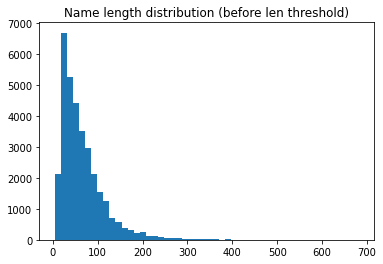

In [36]:
plt.title('Name length distribution (before len threshold)')
plt.hist(list(map(len, quotes_rus)), bins=50);

In [37]:
#set len threshold and add padding
QUANTILE_THRESHOLD = 0.75
len_treshold = int(np.quantile(np.array(list(map(len, quotes_rus))), QUANTILE_THRESHOLD))
quotes_rus = ['_' + line for line in quotes_rus if len(line) <= len_treshold]

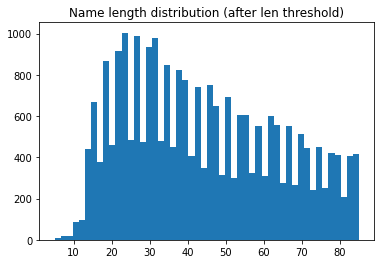

In [38]:
plt.title('Name length distribution (after len threshold)')
plt.hist(list(map(len, quotes_rus)), bins=50);

In [39]:
# #for test
# quote = '_Кушать подано, садитесь жрать!'
# quotes_rus = [quote] * 1000

In [40]:
tokens = list(set(''.join(quotes_rus)))
token_to_id = {token: idx for idx, token in enumerate(tokens)}
num_tokens = len(tokens)
num_tokens, len(quotes_rus)

(162, 24815)

In [41]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [42]:
#Example: cast 4 names to matrices, pad with zeros
print('\n'.join(quotes_rus[::10000]))
print(to_matrix(quotes_rus[::10000], token_to_id))

_Абсолютная власть развращает абсолютно.
_Он умер <…> оттого, что не мог больше жить. Он умер от смерти.
_Нами правит правительство и утренние газеты.
[[ 30  64 150 127 104  23 160  10 158  58  75  19 146  23  58 127  10   1
   19  57  58  66 146  57  58   9  58  47  10  19  58 150 127 104  23 160
   10 158 104 130  19  19  19  19  19  19  19  19  19  19  19  19  19  19
   19  19  19  19  19  19  19  19  19]
 [ 30  55 158  19 122 138  47  57  19  89  73  97  19 104  10  10 104  59
  104  87  19 161  10 104  19 158  47  19 138 104  59  19 150 104  23   1
  126  47  19  60  31  10   1 130  19  55 158  19 122 138  47  57  19 104
   10  19 127 138  47  57  10  31 130]
 [ 30  88  58 138  31  19  21  57  58 146  31  10  19  21  57  58 146  31
   10  47  23   1 127  10 146 104  19  31  19 122  10  57  47 158 158  31
   47  19  59  58  66  47  10 128 130  19  19  19  19  19  19  19  19  19
   19  19  19  19  19  19  19  19  19]]


### Работа с моделями (на основе символов)

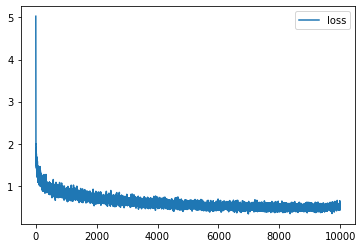

Full train time = 254.35s


In [43]:
#hyperparameters
name='charGRU_emb_size=256_rnn_num_units=1024_rnn_num_layers=1_num_loop=10000'
emb_size=256
RNN_class=nn.GRU #nn.RNN, nn.GRU, or nn.LSTM
rnn_num_units=1024
rnn_num_layers=1
batch_size=32
num_loop=10000
dataset=quotes_rus


MAX_LENGTH = max(map(len, dataset))
model = RNNLoop(num_tokens=num_tokens, emb_size=emb_size, RNN_class=RNN_class,
                rnn_num_units=rnn_num_units, rnn_num_layers=rnn_num_layers)
opt = torch.optim.Adam(model.parameters())
history = []

model, history = train_model(model, opt, dataset, token_to_id, history, num_loop=num_loop, batch_size=batch_size, device=device)

In [44]:
for _ in range(10):
    print(generate_sample_loop(model, max_length=MAX_LENGTH, temperature=1))
print()
print()
for seed_phrase in ['_Если', '_Пусть']:
    print("#{} ##################################".format(seed_phrase))
    for t in [1, 0.1, 1.2]:
        print("Temparature = {}:".format(t))
        for _ in range(10):
            print(generate_sample_loop(model, seed_phrase=seed_phrase, max_length=MAX_LENGTH, temperature=t))
        print()
    print()

_Зеленый друг.                                                                       
_Убей – не больше, чем люблю. Оная будь и прекрасно.                                 
_сатиры и понаждыт.                                                                  
_Правители – это ядики.                                                              
_Утро нашей Родины.                                                                  
_А новые идею – это не люблю.                                                        
_Люди могут пожаром без Итаков.                                                      
_Все, что может грезит, натисят, но надо просить за чтонинг.                         
_По мне же нам чужую пипу.                                                           
_Я дал буду свойственно с неба, по которому что лишь один из тоже он.                


#_Если ##################################
Temparature = 1:
_Если хочешь быть здоровым, но борьба за двободы.                              

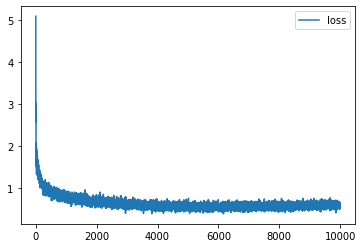

Full train time = 518.07s


In [45]:
#hyperparameters
name='charGRU_emb_size=256_rnn_num_units=1024_rnn_num_layers=3_num_loop=10000'
emb_size=256
RNN_class=nn.GRU #nn.RNN, nn.GRU, or nn.LSTM
rnn_num_units=1024
rnn_num_layers=3
batch_size=32
num_loop=10000
dataset=quotes_rus


MAX_LENGTH = max(map(len, dataset))
model = RNNLoop(num_tokens=num_tokens, emb_size=emb_size,  RNN_class=RNN_class, 
                rnn_num_units=rnn_num_units, rnn_num_layers=rnn_num_layers)
opt = torch.optim.Adam(model.parameters())
history = []

model, history = train_model(model, opt, dataset, token_to_id, history, num_loop=num_loop, batch_size=batch_size, device=device)

In [46]:
for _ in range(10):
    print(generate_sample_loop(model, max_length=MAX_LENGTH, temperature=1))
print()
print()
for seed_phrase in ['_Если', '_Пусть']:
    print("#{} ##################################".format(seed_phrase))
    for t in [1, 0.1, 1.2]:
        print("Temparature = {}:".format(t))
        for _ in range(10):
            print(generate_sample_loop(model, seed_phrase=seed_phrase, max_length=MAX_LENGTH, temperature=t))
        print()
    print()

_Мать — это тот, как только вы слышите, как моя флетичная.                           
_Отсут их суд появится – ты рановитерия я терпение одного оказание за осожайся.      
_В ваше вческие дву – / Это такая проблемы / Велезна / Только во умели, жите – / Это 
_Друг давно вымерства – тожит.                                                       
_Хазен ты – не знаете ей минит судеб.                                                
_Социализм – это не призрак комментарином.                                           
_Вы делаеше, как деревнее, каковы ведетеры.                                          
_Да изобрества никогда не бывает.  Никого за бедным другом.                          
_Мужчины несобчитыство.                                                              
_В большим кратках мянеты врагители правление мужа, они были взойным.                


#_Если ##################################
Temparature = 1:
_Если готовите свой хорош, но не с ней, / я бы осталось никого не мог.         

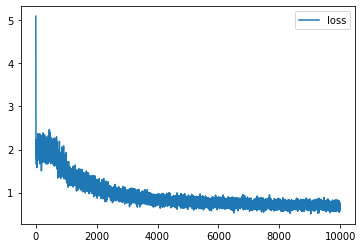

Full train time = 960.06s


In [47]:
#hyperparameters
name='charGRU_emb_size=256_rnn_num_units=1024_rnn_num_layers=6_num_loop=10000'
emb_size=256
RNN_class=nn.GRU #nn.RNN, nn.GRU, or nn.LSTM
rnn_num_units=1024
rnn_num_layers=6
batch_size=32
num_loop=10000
dataset=quotes_rus


MAX_LENGTH = max(map(len, dataset))
model = RNNLoop(num_tokens=num_tokens, emb_size=emb_size,  RNN_class=RNN_class, 
                rnn_num_units=rnn_num_units, rnn_num_layers=rnn_num_layers)
opt = torch.optim.Adam(model.parameters())
history = []

model, history = train_model(model, opt, dataset, token_to_id, history, num_loop=num_loop, batch_size=batch_size, device=device)

In [48]:
for _ in range(10):
    print(generate_sample_loop(model, max_length=MAX_LENGTH, temperature=1))
print()
print()
for seed_phrase in ['_Если', '_Пусть']:
    print("#{} ##################################".format(seed_phrase))
    for t in [1, 0.1, 1.2]:
        print("Temparature = {}:".format(t))
        for _ in range(10):
            print(generate_sample_loop(model, seed_phrase=seed_phrase, max_length=MAX_LENGTH, temperature=t))
        print()
    print()

_Вперед, повтори, лишь мертвый двигнодрившая моя.                                    
_Железала мавателей – на не сказать «РII, Э не верь, не бежитцу.                     
_Бывали свою сомертна, пластер на войну.                                             
_Усерженна есть Барабор вагона.                                                      
_Запрещено правители: поэтом на посулесе с верь.                                     
_Ипотуция дураками.                                                                  
_1. Ведь полечательствут получивать не убилеюва, когдефеет и тогда.                  
_Если мы видили поображим нас на народочей в искейников, повдуж действие законов не б
_Наше памдает нам Рим и победить смерти, я колима и бог.                             
_Больше знает за дело без победному, что <…> заве любит <…>.                         


#_Если ##################################
Temparature = 1:
_Если на все можно платить против того, что нас или попрожи.                   

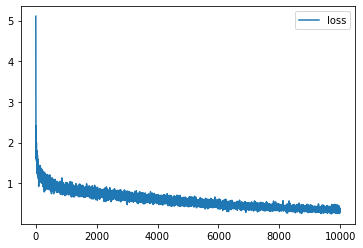

Full train time = 307.31s


In [49]:
#hyperparameters
name='charLSTM_emb_size=256_rnn_num_units=1024_rnn_num_layers=1_num_loop=10000'
emb_size=256
RNN_class=nn.LSTM #nn.RNN, nn.GRU, or nn.LSTM
rnn_num_units=1024
rnn_num_layers=1
batch_size=32
num_loop=10000
dataset=quotes_rus


MAX_LENGTH = max(map(len, dataset))
model = RNNLoop(num_tokens=num_tokens, emb_size=emb_size, RNN_class=RNN_class,
                rnn_num_units=rnn_num_units, rnn_num_layers=rnn_num_layers)
opt = torch.optim.Adam(model.parameters())
history = []

model, history = train_model(model, opt, dataset, token_to_id, history, num_loop=num_loop, batch_size=batch_size, device=device)

In [50]:
for _ in range(10):
    print(generate_sample_loop(model, max_length=MAX_LENGTH, temperature=1))
print()
print()
for seed_phrase in ['_Если', '_Пусть']:
    print("#{} ##################################".format(seed_phrase))
    for t in [1, 0.1, 1.2]:
        print("Temparature = {}:".format(t))
        for _ in range(10):
            print(generate_sample_loop(model, seed_phrase=seed_phrase, max_length=MAX_LENGTH, temperature=t))
        print()
    print()

_Вовремя управляет себя работу, не имеет право на нас.                               
_Еще не принятая рука телефона.                                                      
_Лохи, глупость обращаться к пользую.                                                
_Аристократия денежного мешка.                                                       
_Проклятая до фиска — самый советский надеют обстоятельствовать только тогда, когда п
_О чем и вечный поля родил Бог, что вам не хочу  Товарищу».                          
_На челесо личного ненависти <…> 93i века!                                           
_Земля наша велика одушевления в святая твариата.                                    
_Побеждающий не потерпит пред обманунии.                                             
_Генерал, далеко дойти не было, – можно разговорование.                              


#_Если ##################################
Temparature = 1:
_Если бы Бога не думал, если бы Роган-одно.                                    

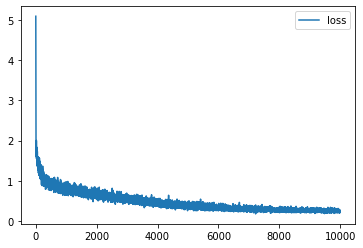

Full train time = 655.71s


In [51]:
#hyperparameters
name='charLSTM_emb_size=256_rnn_num_units=1024_rnn_num_layers=3_num_loop=10000'
emb_size=256
RNN_class=nn.LSTM #nn.RNN, nn.GRU, or nn.LSTM
rnn_num_units=1024
rnn_num_layers=3
batch_size=32
num_loop=10000
dataset=quotes_rus


MAX_LENGTH = max(map(len, dataset))
model = RNNLoop(num_tokens=num_tokens, emb_size=emb_size,  RNN_class=RNN_class, 
                rnn_num_units=rnn_num_units, rnn_num_layers=rnn_num_layers)
opt = torch.optim.Adam(model.parameters())
history = []

model, history = train_model(model, opt, dataset, token_to_id, history, num_loop=num_loop, batch_size=batch_size, device=device)

In [52]:
for _ in range(10):
    print(generate_sample_loop(model, max_length=MAX_LENGTH, temperature=1))
print()
print()
for seed_phrase in ['_Если', '_Пусть']:
    print("#{} ##################################".format(seed_phrase))
    for t in [1, 0.1, 1.2]:
        print("Temparature = {}:".format(t))
        for _ in range(10):
            print(generate_sample_loop(model, seed_phrase=seed_phrase, max_length=MAX_LENGTH, temperature=t))
        print()
    print()

_Свежело в первом ряду прекраснеет.                                                  
_Антиквариат – это политик с новой Богом.                                            
_Хоть ты и сейчас,  Ты не сбит с концами.                                            
_Благочестивый обман .                                                               
_Остановит русских вождь н. Завтра! <…> Ты не были так увиду между собой.            
_Семибанкиры емутна карты, читатель таксовки. А комиссионер в 1963 г.                
_Если итки умрут, маки, знающий, ведь о нем режимени.                                
_Наши за границе.                                                                    
_Народ – себе.                                                                       
_Смерть – через Еву, жизнь держис.                                                   


#_Если ##################################
Temparature = 1:
_Если у тебя есть фуниц, язык.                                                 

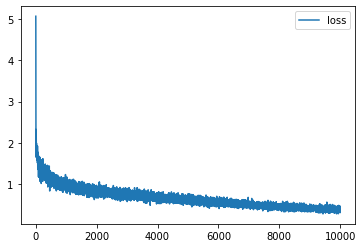

Full train time = 1238.10s


In [53]:
#hyperparameters
name='charLSTM_emb_size=256_rnn_num_units=1024_rnn_num_layers=6_num_loop=10000'
emb_size=256
RNN_class=nn.LSTM #nn.RNN, nn.GRU, or nn.LSTM
rnn_num_units=1024
rnn_num_layers=6
batch_size=32
num_loop=10000
dataset=quotes_rus


MAX_LENGTH = max(map(len, dataset))
model = RNNLoop(num_tokens=num_tokens, emb_size=emb_size,  RNN_class=RNN_class, 
                rnn_num_units=rnn_num_units, rnn_num_layers=rnn_num_layers)
opt = torch.optim.Adam(model.parameters())
history = []

model, history = train_model(model, opt, dataset, token_to_id, history, num_loop=num_loop, batch_size=batch_size, device=device)

In [54]:
for _ in range(10):
    print(generate_sample_loop(model, max_length=MAX_LENGTH, temperature=1))
print()
print()
for seed_phrase in ['_Если', '_Пусть']:
    print("#{} ##################################".format(seed_phrase))
    for t in [1, 0.1, 1.2]:
        print("Temparature = {}:".format(t))
        for _ in range(10):
            print(generate_sample_loop(model, seed_phrase=seed_phrase, max_length=MAX_LENGTH, temperature=t))
        print()
    print()

_Мира дорога, Рожденные – тоже не побело.                                            
_Не отрекаться не из тех, что в Гимне дорогу.                                        
_Все промолы не торгарут в ууак.                                                     
_Король – башня прошлого.                                                            
_Мир есть Но.                                                                        
_Соражение <…> совершил императора.                                                  
_Птичку жалко.                                                                       
_Данбанкь не нужен к славе.                                                          
_Дипломат сонравиков.                                                                
_Авторитет, а не роман, упвайте на силы.                                             


#_Если ##################################
Temparature = 1:
_Если ради просветки святости, тем легче ее править.                           

### Работа с моделями (на основе токенов-слов/знаков)